<a href="https://colab.research.google.com/github/Lok-Tung-Li/Option-Pricing-and-Greek-Calculation/blob/main/Options_Pricing_and_Greeks_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will implement and analyze options pricing models, implement some option Greeks, and compare with open source library `Quantlib`.

1.  Black-Scholes Model: Analytic solutions

2.  Black-Scholes Model: Numerical solutions by finite Difference Method

3.  Binomial Tree: CRR Model

4.  Monte-Carlo simulation: Ordinary and Least Square Methods

5.  Option Greeks

6.  Comparison with `Quantlib`

##1.  Black-Scholes Model: Analytic solutions

###Black-Scholes Equation

Let us recall the derivation of the Black-Scholes formula, using a no arbitrage argument. Assume the price of the underlying asset $S$ follows geometric brownian motion:
$$dS = (\mu-q) Sdt + \sigma SdW$$
where $\mu$ is the drift rate, $\sigma$ is the volatility, $q$ is the dividend yield and $W$ is a Brownian motion.

Let $V=V(S,t)$ be the payoff of an option, as a function of S and t. By Ito's lemma, we have \begin{align*}dV &= \left(\dfrac{\partial V}{\partial t}+\dfrac{1}{2}\dfrac{\partial^2 V}{\partial S^2}\right)dS^2 + \dfrac{\partial V}{\partial S}dS \\
&=\left(\dfrac{\partial V}{\partial t}+(\mu-q) S\dfrac{\partial V}{\partial S}+\dfrac{1}{2}\sigma^2  S^2\dfrac{\partial^2 V}{\partial S^2}\right)dt + \sigma S\dfrac{\partial V}{\partial S}dW \end{align*}

Consider a portfolio $\Pi$, where we short one option $V$, and long $e^{-qt}\dfrac{\partial V}{\partial S}$ shares of S.  

Value of $\Pi$ is:
$$\Pi = -V + (e^{-qt}\dfrac{\partial V}{\partial S})(e^{qt}S) = -V+\dfrac{\partial V}{\partial S}S$$

In the time interval $[t,t+\Delta t]$, we have
\begin{align}\Delta \Pi &= -\Delta V + e^{-qt}\dfrac{\partial V}{\partial S}\Delta (e^{qt}S)=-\Delta V+qS\dfrac{\partial V}{\partial S}\Delta t + \dfrac{\partial V}{\partial S}\Delta S\\
&=\left(-\dfrac{\partial V}{\partial t}-\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2 V}{\partial S^2}+qS\dfrac{\partial V}{\partial S}\right)\Delta t \end{align}
By no-arbitrage, on the other hand we have $$\Delta\Pi= r\Pi \Delta t=\left(-rV+rS\dfrac{\partial V}{\partial S}\right)\Delta t$$where $r$ is the risk-free interest rate.
We conclude the Black-Scholes Equation $$\dfrac{\partial V}{\partial t}+\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2 V}{\partial S^2}+(r-q)S\dfrac{\partial V}{\partial S}-rV =0$$

(Rigorously, we should short $\dfrac{e^{rt}}{V-\frac{\partial V}{\partial S}S}$ of $V$ and long $\dfrac{e^{(r-q)t}\frac{\partial V}{\partial S}}{V-\frac{\partial V}{\partial S}S}$ of $S$, to make the portfolio self-financing.)

###European options: Analytic solution



In [1]:
#import library
from math import log, sqrt, pi, exp
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.style.use('fivethirtyeight')

Consider the case of the price of a European call option $C(S,t)$ with maturity $T$ and strike price $K$. From definition $$C(S,T)=(S-K)^+$$ Using no-arbitrage argument again, we have $$C(0,t)=0,\quad \lim_{S\to\infty} \dfrac{C(S,t)}{S}=1$$
Solving the Black-Scholes Equation, we have $$C(S_t,t) = \Phi(d_1)S_te^{-q(T-t)} - \Phi(d_2)Ke^{-r(T-t)}$$
where $$d_1 = \dfrac{1}{\sigma\sqrt{T-t}}\left[\log\left(\dfrac{S_t}{K}\right)+\left(r+\dfrac{\sigma^2}{2}\right)(T-t)\right]$$
$$d_2 = d_1 - \sigma\sqrt{T-t},\quad \displaystyle \Phi(x) = \dfrac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{z^2/2}dz$$

For a European put option $P(S,t)$ with maturity $T$ and stirke price $K$, from definition we have $P(S,T)=(K-S)^+$. Using put-call parity, $$C(S,t)-P(S,t) = S_te^{-q(T-t)} - Ke^{-r(T-t)}$$
We also have $$P(S_t,t) = \Phi(-d_2)Ke^{-r(T-t)}-\Phi(-d_1)S_te^{-q(T-t)}$$

In [2]:
# Calculate the d1 term in the Black-Scholes formula
def d1(S_0, K, T, r, q, sigma):
    return (log(S_0 / K) + (r - q + sigma**2 / 2) * T) / (sigma * sqrt(T))

# Calculate the d2 term in the Black-Scholes formula
def d2(S_0, K, T, r, q, sigma):
    return d1(S_0, K, T, r, q, sigma) - sigma * sqrt(T)

# Calculate the Black-Scholes price for European call and put options
def BS_European_analytic(S_0, K, T, r, q, sigma, type='call'):
    # Ensure the option type is either 'call' or 'put'
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    if type == 'call':
        # Call option formula
        return (norm.cdf(d1(S_0, K, T, r, q, sigma)) * S_0 * exp(-q * T) -
                norm.cdf(d2(S_0, K, T, r, q, sigma)) * K * exp(-r * T))
    else:
        # Put option formula (using put-call parity)
        return (K * exp(-r * T) - S_0 * exp(-q * T) +
                BS_European_analytic(S_0, K, T, r, q, sigma, 'call'))

# Wrapper function to handle option style and type
def BS_analytic(S_0, K, T, r, q, sigma, style='european', type='call'):
    # Ensure the option type is either 'call' or 'put'
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Ensure the option style is 'european' for analytic solution
    if style != 'european':
        raise ValueError('analytic solution is only for european options')

    return BS_European_analytic(S_0, K, T, r, q, sigma, type)

###Vanilla American Call option

For a vanilla $(q=0)$ American Call option, the price is the same as a vanilla European option.

As American options has more right than their European counterpart, we have $$C_{\text{American}}(S,t) \geq C_{\text{European}}(S,t)$$
On the other hand for American call options $C_{\text{American}}(S,t)$, if is exercised at time $t$
\begin{align}C_{\text{American}}(S,t) &=  S_t-K \\ &\leq S_t-Ke^{r(T-t)} \\ &\leq S_t-Ke^{r(T-t)}+P_{\text{European}}(S,t) = C_{\text{European}}(S,t)\end{align}
By Put-Call parity. If it is not exercised at any $t$, then again $C_{\text{American}}=C_{\text{European}}$.

##2.  Black-Scholes Model: Numerical solutions by finite Difference Method

###Overview and grids

In pricing American call options with dividend, or even vanilla American put options, we have to use numerical methods.

We will consider

1. Explicit finite difference method
2. Implicit finite difference method
3. Crank-Nicolson method

to solve the discretized Black-Scholes Equation.

We begin by forming the grid. We divide $[0,T]$ to $N$ time steps with $\Delta t = \frac{T}{N}$, and $M$ price steps. We will assume the lower and lower bound of $S$ are $(S_{\text{min}},S_{\text{max}}) = (S_0e^{(r-q-\frac{\sigma^2}{2})T-5\sigma\sqrt{T}},S_0e^{(r-q-\frac{\sigma^2}{2})T+5\sigma\sqrt{T}})$, and divide $[S_{\text{min}},S_{\text{max}}]$ to $M$ price steps with $\Delta S = \dfrac{S_{\text{max}}-S_{\text{min}}}{M}$.

Boundary conditions for call options becomes: $$V_{i,N} = ((S_{\text{min}}+i\Delta S)-K)^{+}, \quad V_{0,j} = (S_{\text{min}}-e^{-r(N-j)\Delta t}K)^{+}, \quad \quad V_{M,j} = (S_{\text{max}}-e^{-r(N-j)\Delta t}K)^{+}$$

Boundary conditions for put options becomes: $$V_{i,N} = (K-(S_{\text{min}}+i\Delta S))^{+}, \quad V_{0,j} = (e^{-r(N-j)\Delta t}K-S_{\text{min}})^{+}, \quad \quad V_{M,j} = (e^{-r(N-j)\Delta t}K-S_{\text{max}})^{+}$$

Here, $i$ runs through 0 to $M$, and $j$ runs through $N$ to $0$.

###Explicit finite difference

First, we discretize the Black-Scholes Equation $$\dfrac{\partial V}{\partial t}+\dfrac{1}{2}\sigma^2 S^2\dfrac{\partial^2 V}{\partial S^2}+(r-q)S\dfrac{\partial V}{\partial S}-rV =0$$

Under explicit finite difference approximation, Black-Scholes PDE becomes
$$V_{i,j-1} = a_iV_{i-1,j}+b_iV_{i,j}+c_iV_{i+1,j}
$$ where $$a_i=\frac{1}{2}\Delta t(\sigma^2i^2-(r-q)i),\quad b_i = 1-\Delta t(\sigma^2i^2+r), \quad c_i = \frac{1}{2}\Delta t(\sigma^2i^2+(r-q)i)$$

In [3]:
def BS_Explicit(S_0, K, T, r, q, sigma, N=1000, M=100, style='european', type='call'):
    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Validate the option style
    if style not in ['american', 'european']:
        raise ValueError('style must be either "american" or "european"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Time step size
    dt = T / N

    # Define the range of asset prices
    S_min = 0
    S_max = S_0 * exp((r - q - sigma**2 / 2) * T + 5 * sigma * sqrt(T))

    # Discretize the asset price range
    S = np.linspace(S_min, S_max, M + 1)

    # Coefficients for the finite difference method
    alpha = 0.5 * dt * (sigma**2 * np.arange(0, M + 1)**2 - (r - q) * np.arange(0, M + 1))
    beta = 1 - dt * (sigma**2 * np.arange(0, M + 1)**2 + r)
    gamma = 0.5 * dt * (sigma**2 * np.arange(0, M + 1)**2 + (r - q) * np.arange(0, M + 1))

    # Initialize the option value matrix
    V = np.zeros((M + 1, N + 1))

    # Set the terminal payoff at maturity
    V[:, -1] = np.maximum(sign * (S - K), 0)

    # Boundary conditions at S_min and S_max
    V[0, :] = np.maximum(sign * (S_min - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)
    V[-1, :] = np.maximum(sign * (S_max - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)

    # Backward induction to solve the PDE
    for j in range(N - 1, -1, -1):
        for i in range(1, M):
            # Finite difference equation
            V[i, j] = alpha[i] * V[i - 1, j + 1] + beta[i] * V[i, j + 1] + gamma[i] * V[i + 1, j + 1]

            # Handle early exercise for American options
            if style == 'american':
                V[i, j] = np.maximum(sign * (S[i] - K), V[i, j])

    # Interpolate to get the option price at S_0
    return np.interp(S_0, S, V[:, 0])

## Implicit finite difference

Under implicit finite difference approximation, Black-Scholes PDE becomes
$$V_{i,j+1} = a_iV_{i-1,j}+b_iV_{i,j}+c_iV_{i+1,j}
$$ where $$a_i=-\frac{1}{2}\Delta t(\sigma^2i^2-(r-q)i),\quad b_i = 1+\Delta t(\sigma^2i^2+r), \quad c_i = -\frac{1}{2}\Delta t(\sigma^2i^2+(r-q)i)$$

For each $j$, if we write $V_j = (V_{i,j})_{1\leq i\leq M-1}\in\mathbb{R}^{M-1}$ as a column vector, then the above relation can be written as

$$AV_j = V_{j+1}-a_0V_{0,j}e_{1}-c_{M-1}V_{M,j}e_{M-1}$$
where $e_1=(1,0,\dots,0)^t,e_{M-1}=(0,\dots,0,1)^t$, and $A$ is a tridigonal matirx with $$A = \begin{pmatrix}b_1&c_1&&&\\ a_2&b_2&c_2&&\\
&a_3&\ddots&\ddots& \\
&&\ddots &\ddots&c_{M-2}\\
&&&a_{M-1}&b_{M-1}\end{pmatrix}.$$

Together with the boundary condition, this allows us to solve for $V_j$ by taking inverse of $A$.

In [4]:
def BS_Implicit(S_0, K, T, r, q, sigma, N=1000, M=100, style='european', type='call'):
    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Validate the option style
    if style not in ['american', 'european']:
        raise ValueError('style must be either "american" or "european"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Define the range of asset prices
    S_min = 0
    S_max = S_0 * exp((r - q - sigma**2 / 2) * T + 5 * sigma * sqrt(T))

    # Discretize the asset price range
    S = np.linspace(S_min, S_max, M + 1)

    # Time step size
    dt = T / N

    # Initialize the option value matrix
    V = np.zeros((M + 1, N + 1))

    # Set the terminal payoff at maturity
    V[:, -1] = np.maximum(sign * (S - K), 0)

    # Boundary conditions at S_min and S_max
    V[0, :] = np.maximum(sign * (S_min - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)
    V[-1, :] = np.maximum(sign * (S_max - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)

    # Coefficients for the implicit finite difference method
    alpha = -0.5 * dt * (sigma**2 * np.arange(0, M + 1)**2 - (r - q) * np.arange(0, M + 1))
    beta = 1 + dt * (sigma**2 * np.arange(0, M + 1)**2 + r)
    gamma = -0.5 * dt * (sigma**2 * np.arange(0, M + 1)**2 + (r - q) * np.arange(0, M + 1))

    # Construct the tridiagonal matrix A
    A = np.zeros((M - 1, M - 1))
    A[0, 0] = beta[1]
    A[0, 1] = gamma[1]
    A[-1, -1] = beta[M - 1]
    A[-1, -2] = alpha[M - 1]
    for i in range(1, M - 2):
        A[i, i - 1] = alpha[i + 1]
        A[i, i] = beta[i + 1]
        A[i, i + 1] = gamma[i + 1]

    # Backward induction to solve the PDE
    for j in range(N - 1, -1, -1):
        rhs = V[1:M, j + 1]  # Right-hand side vector
        rhs[0] -= alpha[1] * V[0, j]      # Adjust with boundary condition at S_min
        rhs[-1] -= gamma[M - 1] * V[M, j] # Adjust with boundary condition at S_max

        # Solve the tridiagonal system A * V = rhs
        V[1:-1, j] = np.linalg.solve(A, rhs)

        # Handle early exercise for American options
        if style == 'american':
            V[1:-1, j] = np.maximum(sign * (S[1:-1] - K), V[1:-1, j])

    # Interpolate to get the option price at S_0
    return np.interp(S_0, S, V[:, 0])

##Crank-Nicolson Method

Under Crank-Nicolson finite difference approximation, Black-Scholes PDE becomes
$$-\alpha_iV_{i-1,j-1}+(1-\beta_i)V_{i,j-1}-\gamma_i V_{i+1,j-1}=\alpha_iV_{i-1,j}+(1+\beta_i)V_{i,j}+\gamma_iV_{i+1,j}$$ where $$\alpha_i=\frac{1}{4}\Delta t(\sigma^2i^2-(r-q)i),\quad \beta_i = -\frac{1}{2}\Delta t(\sigma^2i^2+r), \quad \gamma_i = \frac{1}{4}\Delta t(\sigma^2i^2+(r-q)i)$$

For each $j$, if we write $V_j = (V_{i,j})_{1\leq i\leq M-1}\in\mathbb{R}^{M-1}$ as a column vector, then the above relation can be written as

$$A_1V_{j-1} = A_2V_{j}+\alpha_1(V_{0,j-1}+V_{0,j})e_1+\gamma_{M-1}(V_{M,j-1}+V_{M,j})e_{M-1}$$
where $A_1, A_2$ are tridiagonal matrices with $$A_1 = \begin{pmatrix}1-\beta_1&-\gamma_1&&&\\ -\alpha_2&1-\beta_2&-\gamma_2&&\\
&-\alpha_3&\ddots&\ddots& \\
&&\ddots &\ddots&-\gamma_{M-2}\\
&&&-\alpha_{M-1}&1-\beta_{M-1}\end{pmatrix},$$

$$A_2 = \begin{pmatrix}1+\beta_1&\gamma_1&&&\\ \alpha_2&1+\beta_2&\gamma_2&&\\
&\alpha_3&\ddots&\ddots& \\
&&\ddots &\ddots&\gamma_{M-2}\\
&&&\alpha_{M-1}&1+\beta_{M-1}\end{pmatrix}.$$

This allows us to solve for $V_j$ by taking inverse of $A_1$.

In [5]:
def BS_CrankNicolson(S_0, K, T, r, q, sigma, N=1000, M=100, style='european', type='call'):
    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Validate the option style
    if style not in ['american', 'european']:
        raise ValueError('style must be either "american" or "european"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Define the range of asset prices
    S_min = 0
    S_max = S_0 * exp((r - q - sigma**2 / 2) * T + 5 * sigma * sqrt(T))

    # Discretize the asset price range
    S = np.linspace(S_min, S_max, M + 1)

    # Time step size
    dt = T / N

    # Initialize the option value matrix
    V = np.zeros((M + 1, N + 1))

    # Set the terminal payoff at maturity
    V[:, -1] = np.maximum(sign * (S - K), 0)

    # Boundary conditions at S_min and S_max
    V[0, :] = np.maximum(sign * (S_min - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)
    V[-1, :] = np.maximum(sign * (S_max - np.exp(-r * (N - np.arange(0, N + 1)) * dt) * K), 0)

    # Coefficients for the Crank-Nicolson method
    alpha = 0.25 * dt * (sigma**2 * np.arange(0, M + 1)**2 - (r - q) * np.arange(0, M + 1))
    beta = -0.5 * dt * (sigma**2 * np.arange(0, M + 1)**2 + r)
    gamma = 0.25 * dt * (sigma**2 * np.arange(0, M + 1)**2 + (r - q) * np.arange(0, M + 1))

    # Construct the tridiagonal matrix A1 for implicit part
    A1 = np.zeros((M - 1, M - 1))
    A1[0, 0] = 1 - beta[1]
    A1[0, 1] = -gamma[1]
    A1[-1, -1] = 1 - beta[M - 1]
    A1[-1, -2] = -alpha[M - 1]

    for i in range(1, M - 2):
        A1[i, i - 1] = -alpha[i + 1]
        A1[i, i] = 1 - beta[i + 1]
        A1[i, i + 1] = -gamma[i + 1]

    # Construct the tridiagonal matrix A2 for explicit part
    A2 = np.zeros((M - 1, M - 1))
    A2[0, 0] = 1 + beta[1]
    A2[0, 1] = gamma[1]
    A2[-1, -1] = 1 + beta[M - 1]
    A2[-1, -2] = alpha[M - 1]

    for i in range(1, M - 2):
        A2[i, i - 1] = alpha[i + 1]
        A2[i, i] = 1 + beta[i + 1]
        A2[i, i + 1] = gamma[i + 1]

    # Backward induction to solve the PDE using the Crank-Nicolson method
    for j in range(N - 1, -1, -1):
        # Compute the right-hand side (rhs) of the linear system
        rhs = np.matmul(A2, V[1:-1, j + 1])
        rhs[0] += alpha[1] * (V[0, j + 1] + V[0, j])
        rhs[-1] += gamma[M - 1] * (V[M, j + 1] + V[M, j])

        # Solve the linear system A1 * V = rhs
        V[1:-1, j] = np.linalg.solve(A1, rhs)

        # Handle early exercise for American options
        if style == 'american':
            V[1:-1, j] = np.maximum(sign * (S[1:-1] - K), V[1:-1, j])

    # Interpolate to get the option price at S_0
    return np.interp(S_0, S, V[:, 0])

## 3. Binomial Tree: CRR Model

In the binomial tree model, we consider discrete time. The price of our asset $S$ will be $S_0$ at $t=0$. At each step, if $S$ is our current price, the price in the next step will go up to $Su$ with probability $p$, and go down to $Sd$ with probability $1-p$.

At time $t=n$, we have
$$P(S=S_0u^kd^{n-k}) = \binom{n}{k}p^k(1-p)^{n-k}$$

Using the Cox-Ross-Rubinstein model, for a fixed time $T$, we pick $$u=e^{\sigma\sqrt{T/n}}, \quad d=1/u, \quad p=\dfrac{e^{(r-q) T/n}-d}{u-d}$$where $\sigma$ is the volatility of $S$, $r$ is the risk free interest rate, and $p$ is the risk-neutral probability.

To find the value of an option $V(S,t)$, we will use the recursive relation
$$V(S,t) = e^{-rT/n}[pV(Su,t+T/n)+(1-p)V(Sd,t+T/n)]$$
We will produce a binomial tree, and proceed by backward induction.



###Implementation

We will implement the Binomial models for European options and American options. For American options, since the option may either be held or exercised prior to expiry, the value at each node is: Max (Binomial Value, Exercise Value).

In [6]:
def Binomial_Tree(S_0, K, T, r, q, sigma, n=1000, style='european', type='call'):
    # Validate the option style
    if style not in ['american', 'european']:
        raise ValueError('style must be either "american" or "european"')

    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Calculate the up and down factors
    u = exp(sigma * sqrt(T / n))  # Up factor
    d = 1 / u                           # Down factor

    # Calculate the risk-neutral probability
    p = (exp((r - q) * T / n) - d) / (u - d)

    # Initialize the option value array at maturity
    V = [0] * (n + 1)
    for k in range(n + 1):
        V[k] = max(sign * (S_0 * u**k * d**(n - k) - K), 0)

    # Step back through the tree to calculate option value at t=0
    for i in range(n - 1, -1, -1):
        for k in range(i + 1):
            # Risk-neutral valuation
            V[k] = exp(-r * T / n) * (p * V[k + 1] + (1 - p) * V[k])

            # Early exercise for American options
            if style == 'american':
                V[k] = max(sign * (S_0 * u**k * d**(i - k) - K), V[k])

    # Return the option price at the initial node
    return V[0]

##4.  Monte-Carlo simulation: Ordinary and Least Square Methods

In Monte-Carlo method, we simulate paths of the underlying asset, average the payoff and discount the price.

To begin, we recall price of underlying $S$ is a geometric brwonian motion under risk neutral measure:

$$dS = (r-q) Sdt + \sigma SdW$$

i.e. $$S_T = S_t\exp\left(\left(r-q-\frac{\sigma^2}{2}\right)(T-t)+\sigma\sqrt{T-t} W\right)$$

Where $W\sim N(0,1)$, this allows us to perform simulation.

Let's see some examples.

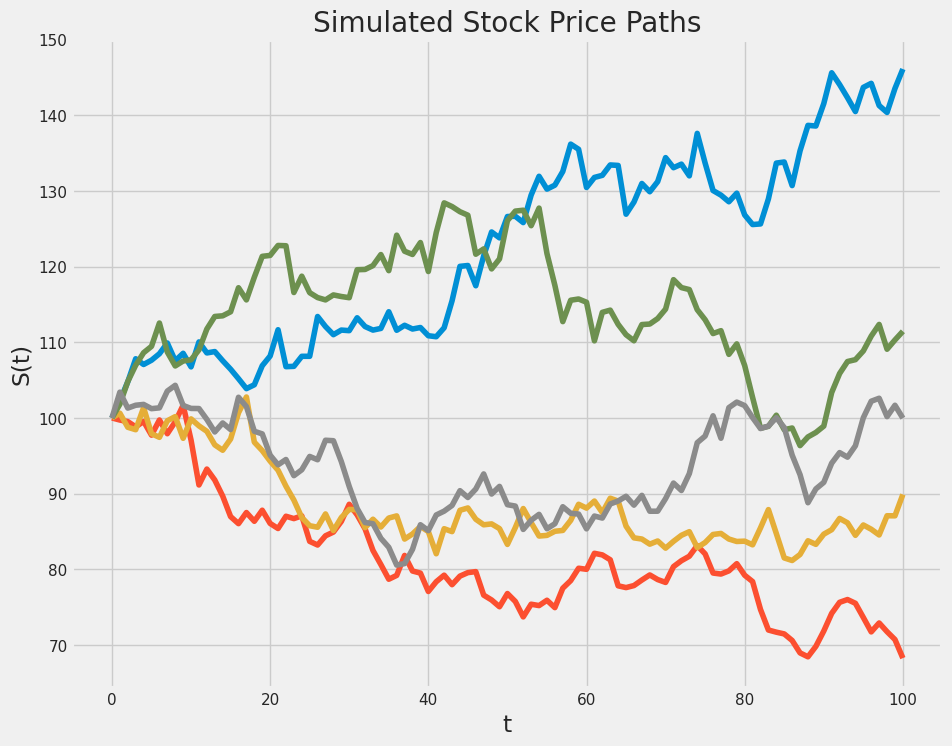

In [7]:
# Set the random seed for reproducibility
np.random.seed(114514)

# Define parameters for the simulation
S0 = 100       # Initial stock price
r = 0.06       # Risk-free interest rate
sigma = 0.2    # Volatility
T = 1          # Time to maturity (in years)
n = 100        # Number of time steps
I = 5          # Number of simulation paths
q = 0.01       # Dividend yield

# Generate random standard normal variates for the simulations
z = np.random.normal(0, 1, (I, n))

# Initialize the array to store simulated paths
S = np.zeros((I, n + 1))
S[:, 0] = S0  # Set initial stock price for all paths

# Simulate the stock price paths using the geometric Brownian motion model
for t in range(1, n + 1):
    S[:, t] = S[:, t - 1] * np.exp((r - q - sigma**2 / 2) * (T / n) + sigma * np.sqrt(T / n) * z[:, t - 1])

# Plot the simulated stock price paths
plt.figure(figsize=(10, 8))
plt.plot(S.T)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Simulated Stock Price Paths')
plt.show()

### European options

For European options, the payoff at time $T$ is simply $$V_{\text{call}}(S,T)=(S_T-K)^+,\quad V_{\text{put}}(S,T)=(K-S_T)^+$$
After discounting to today, the price is $e^{-rT}V$.

In [8]:
def MC_European(S_0, K, T, r, q, sigma, I=10000, type='call'):
    """
    Monte Carlo simulation for European option pricing.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - I: Number of Monte Carlo simulations (default is 10000)
    - type: Option type ('call' or 'put')

    Returns:
    - Option price (present value of expected payoff)
    """

    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Generate random standard normal variates
    z = np.random.normal(0, 1, I)

    # Simulate the stock price at maturity
    ST = S_0 * np.exp((r - q - sigma**2 / 2) * T + sigma * np.sqrt(T) * z)

    # Calculate the present value of the expected payoff
    option_price = np.exp(-r * T) * np.mean(np.maximum(sign * (ST - K), 0))

    return option_price

###American options: Least Square Monte Carlo Method

To price American options, due to the right of early exercise, we will use Least Sqaure Monte Carlo method.

We will first generate full paths of underlying asset $S$. At each $t$, for each path which is in the value, we compute the continuation value $C=\beta X$, where $X$ is the basis functions (for out case: $(1,S,S^2)$) and $\beta$ is regression coefficient of $e^{-rT/n}V(t+T/n)$ against $X$.

Finally, we have $$V(t) = \begin{cases}\text{exercise price}&\text{exercise price}>C \\ e^{-rT/n}V(t+T/n) & \text{otherwise} \end{cases}$$


In [9]:
import numpy as np

def LSMC_American(S0, K, T, r, q, sigma, n=1000, I=10000, type='call'):
    """
    Longstaff-Schwartz Monte Carlo method for American option pricing.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - n: Number of time steps (default is 1000)
    - I: Number of Monte Carlo simulations (default is 10000)
    - type: Option type ('call' or 'put')

    Returns:
    - Estimated price of the American option
    """

    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Determine sign for call (1) or put (-1) option
    sign = 1 if type == 'call' else -1

    # Generate random standard normal variates for the simulations
    z = np.random.normal(0, 1, (I, n))

    # Initialize the stock price matrix
    S = np.zeros((I, n + 1))
    S[:, 0] = S0  # Set the initial stock price for all paths

    # Simulate the stock price paths using the geometric Brownian motion model
    for t in range(1, n + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - q - sigma**2 / 2) * (T / n) + sigma * np.sqrt(T / n) * z[:, t - 1])

    # Initialize the option value at maturity
    V = np.maximum(sign * (S[:, n] - K), 0)

    # Step backward through the tree to estimate the continuation value
    for t in range(n - 1, -1, -1):
        in_the_money = sign * (S[:, t] - K) > 0  # Check if option is in the money

        # Use linear regression to estimate continuation value
        X = np.column_stack((np.ones_like(S[in_the_money, t]), S[in_the_money, t], S[in_the_money, t]**2))
        beta = np.linalg.lstsq(X, V[in_the_money] * np.exp(-r * (T / n)), rcond=None)[0]
        C = np.dot(X, beta)

        # Update option values where early exercise is optimal
        V[in_the_money] = np.where(sign * (S[in_the_money, t] - K) > C,
                                   sign * (S[in_the_money, t] - K),
                                   V[in_the_money] * np.exp(-r * (T / n)))

        # Discount the value for paths that are out of the money
        V[~in_the_money] = np.exp(-r * (T / n)) * V[~in_the_money]

    # Return the mean value as the estimated option price
    return np.mean(V)

def MC(S_0, K, T, r, q, sigma, n=1000, I=10000, style='european', type='call'):
    """
    Monte Carlo method for option pricing (European and American).

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - n: Number of time steps (default is 1000)
    - I: Number of Monte Carlo simulations (default is 10000)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')

    Returns:
    - Estimated price of the option (European or American)
    """

    # Validate the option type
    if type not in ['call', 'put']:
        raise ValueError('type must be either "call" or "put"')

    # Validate the option style
    if style not in ['american', 'european']:
        raise ValueError('style must be either "american" or "european"')

    # Compute the option price based on style
    if style == 'american':
        return LSMC_American(S_0, K, T, r, q, sigma, n, I, type)
    else:
        return MC_European(S_0, K, T, r, q, sigma, I, type)


##5. Greeks

The code calculates five key option Greeks, which measure the sensitivities of an option's price $V$ to various factors:

- **Delta (Δ)**: Sensitivity to the underlying asset's price (S), $\Delta = \dfrac{\partial V}{\partial S}$.
- **Vega (\(\mathcal{V}\))**: Sensitivity to volatility $\sigma$, $\mathcal{V} = \dfrac{\partial V}{\partial \sigma}$.
- **Theta (Θ)**: Sensitivity to time $T$, $\Theta = -\dfrac{\partial V}{\partial T}$.
- **Rho (ρ)**: Sensitivity to the risk-free interest rate $r$, $\rho = \dfrac{\partial V}{\partial r}$.
- **Gamma (Γ)**: Sensitivity of Delta to the asset's price, $\Gamma = \dfrac{\partial^2 V}{\partial S^2}$.

These Greeks are calculated using three finite difference methods: forward, central, and backward differences, providing flexibility and accuracy in the estimations.

In [10]:
# Dictionary mapping implementation methods to corresponding functions
function_dict = {
    'explicit': BS_Explicit,
    'implicit': BS_Implicit,
    'cn': BS_CrankNicolson,
    'btree': Binomial_Tree,
    'analytic': BS_analytic,
    'mc': MC
}

def check_input(style, type, method, implement):
    """
    Validate the inputs for the Greeks calculation functions.

    Parameters:
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('forward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Raises:
    - ValueError: If an invalid method or implementation is provided.
    """
    if method not in ['foward', 'central', 'backward']:
        raise ValueError('method must be either "foward", "central", or "backward"')
    if implement not in ['explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic']:
        raise ValueError('implement must be either "explicit", "implicit", "cn", "btree", "mc", or "analytic"')

def Delta(S_0, K, T, r, q, sigma, ds=0.0001, style='european', type='call', method='foward', implement='explicit'):
    """
    Calculate the Delta of an option using finite differences.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - ds: Small change in stock price (default is 0.0001)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('foward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Returns:
    - Delta of the option
    """
    check_input(style, type, method, implement)
    option = function_dict[implement]

    if method == 'foward':
        return (option(S_0 + ds, K, T, r, q, sigma, style=style, type=type) - option(S_0, K, T, r, q, sigma, style=style, type=type)) / ds
    elif method == 'central':
        return (option(S_0 + ds, K, T, r, q, sigma, style=style, type=type) - option(S_0 - ds, K, T, r, q, sigma, style=style, type=type)) / (2 * ds)
    elif method == 'backward':
        return (option(S_0, K, T, r, q, sigma, style=style, type=type) - option(S_0 - ds, K, T, r, q, sigma, style=style, type=type)) / ds

def Vega(S_0, K, T, r, q, sigma, dsigma=0.0001, style='european', type='call', method='foward', implement='explicit'):
    """
    Calculate the Vega of an option using finite differences.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - dsigma: Small change in volatility (default is 0.0001)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('foward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Returns:
    - Vega of the option
    """
    check_input(style, type, method, implement)
    option = function_dict[implement]

    if method == 'foward':
        return (option(S_0, K, T, r, q, sigma + dsigma, style=style, type=type) - option(S_0, K, T, r, q, sigma, style=style, type=type)) / dsigma
    elif method == 'central':
        return (option(S_0, K, T, r, q, sigma + dsigma, style=style, type=type) - option(S_0, K, T, r, q, sigma - dsigma, style=style, type=type)) / (2 * dsigma)
    elif method == 'backward':
        return (option(S_0, K, T, r, q, sigma, style=style, type=type) - option(S_0, K, T, r, q, sigma - dsigma, style=style, type=type)) / dsigma

def Theta(S_0, K, T, r, q, sigma, dt=0.0001, style='european', type='call', method='foward', implement='explicit'):
    """
    Calculate the Theta of an option using finite differences.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - dt: Small change in time (default is 0.0001)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('foward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Returns:
    - Theta of the option
    """
    check_input(style, type, method, implement)
    option = function_dict[implement]

    if method == 'foward':
        return (option(S_0, K, T - dt, r, q, sigma, style=style, type=type) - option(S_0, K, T, r, q, sigma, style=style, type=type)) / dt
    elif method == 'central':
        return (option(S_0, K, T - dt, r, q, sigma, style=style, type=type) - option(S_0, K, T + dt, r, q, sigma, style=style, type=type)) / (2 * dt)
    elif method == 'backward':
        return (option(S_0, K, T, r, q, sigma, style=style, type=type) - option(S_0, K, T + dt, r, q, sigma, style=style, type=type)) / dt

def Rho(S_0, K, T, r, q, sigma, dr=0.0001, style='european', type='call', method='foward', implement='explicit'):
    """
    Calculate the Rho of an option using finite differences.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - dr: Small change in interest rate (default is 0.0001)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('foward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Returns:
    - Rho of the option
    """
    check_input(style, type, method, implement)
    option = function_dict[implement]

    if method == 'foward':
        return (option(S_0, K, T, r + dr, q, sigma, style=style, type=type) - option(S_0, K, T, r, q, sigma, style=style, type=type)) / dr
    elif method == 'central':
        return (option(S_0, K, T, r + dr, q, sigma, style=style, type=type) - option(S_0, K, T, r - dr, q, sigma, style=style, type=type)) / (2 * dr)
    elif method == 'backward':
        return (option(S_0, K, T, r, q, sigma, style=style, type=type) - option(S_0, K, T, r - dr, q, sigma, style=style, type=type)) / dr

def Gamma(S_0, K, T, r, q, sigma, ds=0.0001, style='european', type='call', method='foward', implement='explicit'):
    """
    Calculate the Gamma of an option using finite differences.

    Parameters:
    - S_0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - ds: Small change in stock price (default is 0.0001)
    - style: Option style ('american' or 'european')
    - type: Option type ('call' or 'put')
    - method: Finite difference method ('foward', 'central', 'backward')
    - implement: Implementation method ('explicit', 'implicit', 'cn', 'btree', 'mc', 'analytic')

    Returns:
    - Gamma of the option
    """
    check_input(style, type, method, implement)
    option = function_dict[implement]

    if method == 'foward':
        return (option(S_0 + 2 * ds, K, T, r, q, sigma, style=style, type=type) - 2 * option(S_0 + ds, K, T, r, q, sigma, style=style, type=type) + option(S_0, K, T, r, q, sigma, style=style, type=type)) / (ds**2)
    elif method == 'central':
        return (option(S_0 + ds, K, T, r, q, sigma, style=style, type=type) - 2 * option(S_0, K, T, r, q, sigma, style=style, type=type) + option(S_0 - ds, K, T, r, q, sigma, style=style, type=type)) / (ds**2)
    elif method == 'backward':
        return (option(S_0, K, T, r, q, sigma, style=style, type=type) - 2 * option(S_0 - ds, K, T, r, q, sigma, style=style, type=type) + option(S_0 - 2 * ds, K, T, r, q, sigma, style=style, type=type)) / (ds**2)


## 6. Comparison with `Quantlib`


In this section,  we compare our previous implementation with the open library `Quantlib`.

In [11]:
pip install QuantLib-Python

Let's compare the price of a European Call option using analytic method in `Quantlib`.

In [12]:
import QuantLib as ql

# Option data
spot_price = 100.0  # Current stock price
strike_price = 100.0  # Strike price
maturity_date = ql.Date(31, 12, 2023)  # Option maturity date
volatility = 0.20  # Historical volatility of the underlying asset
risk_free_rate = 0.05  # Risk-free interest rate
dividend_yield = 0.02  # Dividend yield

# QuantLib settings
calendar = ql.NullCalendar()
day_count = ql.SimpleDayCounter()
calculation_date = ql.Date(31, 12, 2022)
ql.Settings.instance().evaluationDate = calculation_date

# Option type (Call)
payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike_price)
exercise = ql.EuropeanExercise(maturity_date)

# Create the option
european_option = ql.VanillaOption(payoff, exercise)

# Black-Scholes process
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_yield, day_count))
volatility_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))

bs_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield_ts, flat_ts, volatility_ts)

# Pricing the option using Black-Scholes formula
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bs_process))

# Option price
option_price = european_option.NPV()
print(f"European Call Option Price by Quantlib: {option_price}")

European Call Option Price by Quantlib: 9.227005508154061


In [13]:
methods = {'Analytic':BS_analytic,'Explicit':BS_Explicit,'Implicit':BS_Implicit,'Crank-Nicolson':BS_CrankNicolson,'Binomial Tree':Binomial_Tree,'Monte-Carlo':MC}
for name, func in methods.items():
  print(f"European Call Option Price by {name} method: {func(spot_price,strike_price,1,risk_free_rate,dividend_yield,volatility,style = 'european', type = 'call')}")

European Call Option Price by Analytic method: 9.227005508154043
European Call Option Price by Explicit method: 9.24482032272267
European Call Option Price by Implicit method: 9.242597252870802
European Call Option Price by Crank-Nicolson method: 9.24370896085804
European Call Option Price by Binomial Tree method: 9.2250617378441
European Call Option Price by Monte-Carlo method: 9.363557371019045


We see that all the method are quite close. The Monte-Carlo method differs slightly, which we guess can be imrpoved by increasing number of iterations.

For a European put option, our method looks like this:

In [14]:
for name, func in methods.items():
  print(f"European Put Option Price by {name} method: {func(spot_price,strike_price,1,risk_free_rate,dividend_yield,volatility,style = 'european', type = 'put')}")

European Put Option Price by Analytic method: 6.3300806275499255
European Put Option Price by Explicit method: 6.347795898205775
European Put Option Price by Implicit method: 6.345771380623305
European Put Option Price by Crank-Nicolson method: 6.346783815843518
European Put Option Price by Binomial Tree method: 6.328136857244768
European Put Option Price by Monte-Carlo method: 6.4927178631613085


Let's compare the price of an American Put option using CRR method in `Quantlib`.

In [15]:
# Option type (Put)
payoff = ql.PlainVanillaPayoff(ql.Option.Put, strike_price)
exercise = ql.AmericanExercise(calculation_date, maturity_date)

# Create the option
american_option = ql.VanillaOption(payoff, exercise)

# Black-Scholes process
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_yield, day_count))
volatility_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))

bs_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield_ts, flat_ts, volatility_ts)

# Pricing the option using Binomial tree method (Cox-Ross-Rubinstein model)
binomial_engine = ql.BinomialVanillaEngine(bs_process, "crr", 1000)
american_option.setPricingEngine(binomial_engine)

# Option price
option_price = american_option.NPV()
print(f"American Put Option Price: {option_price}")

American Put Option Price: 6.659768779152895


In [16]:
methods = {'Explicit':BS_Explicit,'Implicit':BS_Implicit,'Crank-Nicolson':BS_CrankNicolson,'Binomial Tree':Binomial_Tree,'Monte-Carlo':MC}
for name, func in methods.items():
  print(f"American Put Option Price by {name} method: {func(spot_price,strike_price,1,risk_free_rate,dividend_yield,volatility,style = 'american', type = 'put')}")

American Put Option Price by Explicit method: 6.674394474029806
American Put Option Price by Implicit method: 6.67100838070447
American Put Option Price by Crank-Nicolson method: 6.6726940679145414
American Put Option Price by Binomial Tree method: 6.659759199384019
American Put Option Price by Monte-Carlo method: 6.622172698547084


The price matches our Binomial Tree implementation nicely. Other implementations also come very closely.

Finally let's have a look at the price of American Call option.

In [17]:
for name, func in methods.items():
  print(f"American Call Option Price by {name} method: {func(spot_price,strike_price,1,risk_free_rate,dividend_yield,volatility,style = 'american', type = 'call')}")

American Call Option Price by Explicit method: 9.244820327046916
American Call Option Price by Implicit method: 9.242597256763087
American Call Option Price by Crank-Nicolson method: 9.24370896496268
American Call Option Price by Binomial Tree method: 9.2250617710089
American Call Option Price by Monte-Carlo method: 9.27911112347842
